## ROC Functions 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline


#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-', THRESHOLD='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    if(not(THRESHOLD is '-')):
        obj['THRESHOLD'] = THRESHOLD
    return obj



#makes ROC_DATA for a all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    THRESHOLD = []
    for i in range(0, 100):
        threshold=i/100.
        THRESHOLD.append(threshold)
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN, THRESHOLD=THRESHOLD)

#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotRocThreshold(rocData):
    fig = plt.figure()
    fig.set_size_inches(5, 5)
    ax = fig.add_subplot(1,1,1)
    
    d = skimROC_Data(rocData, addTresh=True)
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']

    ax.plot(FP,TP,'-' ,label = "FP", alpha=.8, color='black')
    ax.plot(THRESHOLD,TP,'-' ,label = "Threshold", color='red', linewidth = .5)

    ax.set_xlabel('%')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP %')
    ax.set_ylim(0,1)
    ax.set_title(label+ " ROC + Thresholds")
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend()


#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = skimROC_Data(rocData)
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-' ,label = label,zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('FP Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title('ROC Curve Compliation')
    ax.legend()
    
    
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = 1.):
    for c in df.drop(columns=ignore).columns:
#         df[c].loc[df[c] >= N] = N
#         print(df[c].dtype)
        if(not (df[c].dtype == 'bool')):
            df[c] = df[c].where(df[c] <= 1., 1.) 
    return df


#Takes the average of all columns in a df
def avgVal(df, ignore = ['Success'], colName = "AvgPred", JUST_PREDS=False):
#     if(JUST_PREDS):
#         for col in df.columns:
#             if(not(col[:4]=='Pred')):
#                 ignore.append(col)
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df

def skimROC_Data(d, addTresh=False):
    x, y = [], []
    t = []
    for i in range(0, len(d['FP'])):
        curX, curY = d['FP'][i], d['TP'][i]
        if(addTresh):
            curT = d['THRESHOLD'][i]
        if(len(x) == 0):
            x.append(curX)
            y.append(curY)
            if(addTresh):
                t.append(curT)
        elif(not curX == x[-1:][0]):
            x.append(curX)
            y.append(curY)
            if(addTresh):
                t.append(curT)
    data = {"Label":d['Label'], 'FP':x, 'TP':y}
    if(addTresh):
        data['THRESHOLD'] = t
    return data

def rocPercent(roc):
    data = skimROC_Data(roc)
    f = InterpolatedUnivariateSpline(data['FP'], data['TP'], k=1)
    plt.plot(f)
    return data['Label'] + "'s Integral is: "+str(f.integral(0.,1.))

def rocPercents(rocData):
    for roc in rocData:
        pct = rocPercent(roc)
        print(pct)


## Forest Functions

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate numnber of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    failDF = df[df[colName]==False]
    successDF = df[df[colName]==True]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None', basedOnVault=False):
    if(not basedOnVault):
        df = df.copy(deep=True)
        if(TYPE=="CLF"):
            df['Success'] = df['Success'].astype('int')
        elif(TYPE=='REGR'):
            df['Success'] = df['Success'].astype('float')
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
        trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
        df = df.drop(columns=['is_train'], axis=1)
        trainDF = trainDF.drop(['is_train'], axis=1)
        testDF = testDF.drop(['is_train'], axis=1)
        return trainDF, testDF
    else:
        nonVault = pd.merge(nonVaultDF, df, on='ContestId', how='left')
        vault = df[~df.index.isin(nonVault.index)].dropna()
#         return len(vault), len(nonVault)
        numTrain = len(nonVault)
        numTest = int((1-percentTrain)*numTrain)
        vault.sample(n=numTest, random_state=1)
        return nonVault, vault.sample(n=numTest, random_state=1)


#Simple wrapper for a making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided 
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'): ####################
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf


def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 20, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

### Data Files for ROC

In [4]:
fullContests = pd.read_csv('data/WorkingData.csv').set_index('ContestId')

In [11]:
# Percent Full at 4 hours out
baselineDF = pd.read_csv('data/baseline.csv').drop(columns=['Unnamed: 0'])

# Meta Data file
metaDataDF = pd.read_csv('data/MetaData.csv')

# Kalman Filter
kfResultsDF = pd.read_csv('data/KF_Results.csv')
kfsResultsDF = pd.read_csv('data/KF_Scaled_Results.csv')

# Linear Regression
lrResultsDF = pd.read_csv('data/LR_Results.csv')
lrsResultsDF = pd.read_csv('data/LR_Scaled_Results.csv')

In [ ]:
trainDF = pd.read_csv("dataVault/train.csv").set_index('ContestId')
testDF = pd.read_csv("dataVault/vault1.csv").set_index('ContestId')
print("Number of contests in trainDF:",len(trainDF))
print("Number of contests in testDF:",len(testDF))

### Calculating ROC_DATA

Baseline ROC Generation

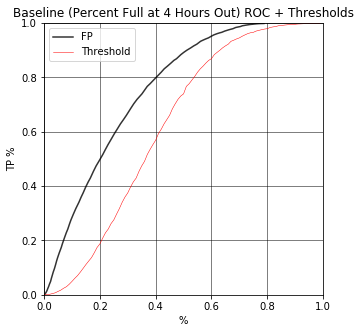

In [7]:
# print("... Calculating Baseline 4-hours-out Prediction")
baselineRates = getRate(baselineDF, 'FourHoursOut_Scaled', label='Baseline (Percent Full at 4 Hours Out)')
plotRocThreshold(baselineRates)

Meta Data ROC Generation

In [8]:
metaColumns = list(metaDataDF.columns.drop('ContestId'))
metaColumns.append('Success')
metaTrain, metaTest = trainDF[metaColumns], testDF[metaColumns]

In [9]:
metaCLFS = EnsembleWithMinAcc(limitVal(metaTrain), RandomForestClassifier, accuracy = .6)
metaPreds = avgVal(getEnsPred(limitVal(metaTest), metaCLFS))

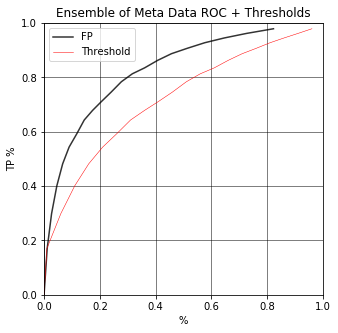

In [10]:
metaEnsembleRates =  getRate(metaPreds, 'AvgPred', label='Ensemble of Meta Data')
plotRocThreshold(metaEnsembleRates)

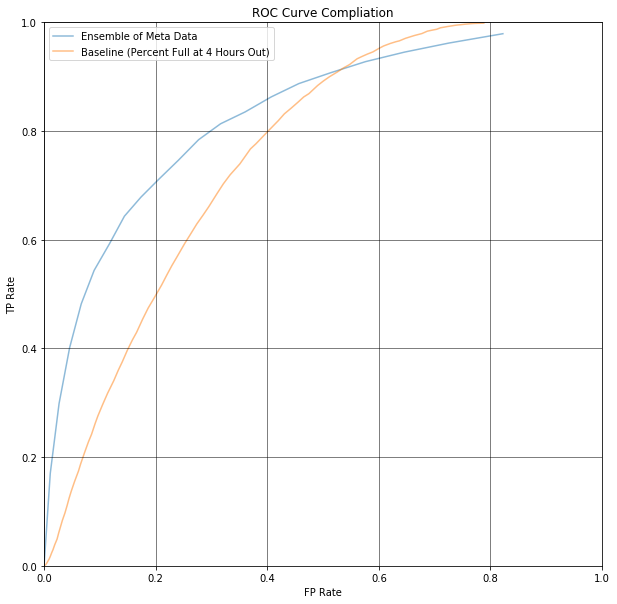

In [11]:
plotRocs([metaEnsembleRates, baselineRates])

Kalman Filter ROC Generation

In [12]:
kfColumns = list(kfResultsDF.columns.drop('ContestId'))
kfColumns.append('Success')
kfTrain, kfTest = trainDF[kfColumns], testDF[kfColumns]

In [13]:
# kfAvgRate = getRate(avgVal(limitVal(kfTest, N=1.), JUST_PREDS=True), 'AvgPred', label='Average Kalman Prediction')
# plotRocThreshold(kfAvgRate)

In [14]:
kfCLFS = EnsembleWithMinAcc(limitVal(kfTrain, N=1.), RandomForestClassifier, accuracy = .6)
kfPreds = avgVal(getEnsPred(limitVal(kfTest, N=1.), kfCLFS))

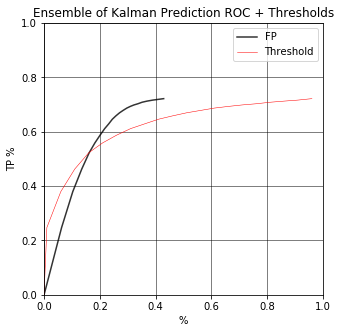

In [15]:
kfEnsembleRates =  getRate(kfPreds, 'AvgPred', label='Ensemble of Kalman Prediction')
plotRocThreshold(kfEnsembleRates)

Linear Regression ROC Generation

In [16]:
lrColumns = list(lrResultsDF.columns.drop('ContestId'))
lrColumns.append('Success')
lrTrain, lrTest = trainDF[lrColumns], testDF[lrColumns]

In [17]:
# lrAvgRate = getRate(avgVal(limitVal(lrTest, N=1.), JUST_PREDS=True), 'AvgPred', label='Average Linear Regression Prediction')
# plotRocThreshold(lrAvgRate)

In [18]:
lrCLFS = EnsembleWithMinAcc(limitVal(lrTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrPreds = avgVal(getEnsPred(limitVal(lrTest, N=1.), lrCLFS))

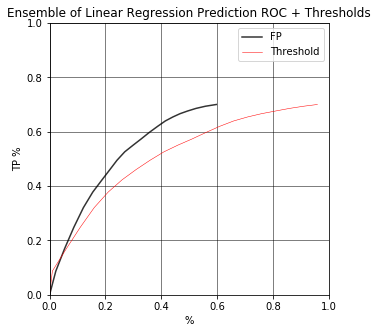

In [19]:
lrEnsembleRates =  getRate(lrPreds, 'AvgPred', label='Ensemble of Linear Regression Prediction')
plotRocThreshold(lrEnsembleRates)

### Scaled

In [20]:
kfsColumns = list(kfsResultsDF.columns.drop('ContestId'))
kfsColumns.append('Success')
kfsTrain, kfsTest = trainDF[kfsColumns], testDF[kfsColumns]

KeyError: "['A_KFS_v1' 'A_KFS_v10' 'A_KFS_v11' 'A_KFS_v12' 'A_KFS_v13' 'A_KFS_v14'\n 'A_KFS_v15' 'A_KFS_v2' 'A_KFS_v3' 'A_KFS_v4' 'A_KFS_v5' 'A_KFS_v6'\n 'A_KFS_v7' 'A_KFS_v8' 'A_KFS_v9' 'B_KFS_v1' 'B_KFS_v10' 'B_KFS_v11'\n 'B_KFS_v12' 'B_KFS_v13' 'B_KFS_v14' 'B_KFS_v15' 'B_KFS_v2' 'B_KFS_v3'\n 'B_KFS_v4' 'B_KFS_v5' 'B_KFS_v6' 'B_KFS_v7' 'B_KFS_v8' 'B_KFS_v9'\n 'Pred_KFS_v1' 'Pred_KFS_v10' 'Pred_KFS_v11' 'Pred_KFS_v12' 'Pred_KFS_v13'\n 'Pred_KFS_v14' 'Pred_KFS_v15' 'Pred_KFS_v2' 'Pred_KFS_v3' 'Pred_KFS_v4'\n 'Pred_KFS_v5' 'Pred_KFS_v6' 'Pred_KFS_v7' 'Pred_KFS_v8' 'Pred_KFS_v9'] not in index"

In [ ]:
# kfsAvgRate = getRate(avgVal(limitVal(kfsTest, N=1.)), 'AvgPred', label='Average SCALED Kalman Prediction')
# plotRocThreshold(kfsAvgRate)

In [ ]:
kfsCLFS = EnsembleWithMinAcc(limitVal(kfsTrain, N=1.), RandomForestClassifier, accuracy = .6)
kfsPreds = avgVal(getEnsPred(limitVal(kfsTest, N=1.), kfsCLFS))

In [ ]:
kfsEnsembleRates =  getRate(kfsPreds, 'AvgPred', label='Ensemble of SCALED Kalman Prediction')
plotRocThreshold(kfsEnsembleRates)

In [ ]:
lrsColumns = list(lrsResultsDF.columns.drop('ContestId'))
lrsColumns.append('Success')
lrsTrain, lrsTest = trainDF[lrsColumns], testDF[lrsColumns]

In [ ]:
lrsCLFS = EnsembleWithMinAcc(limitVal(lrsTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrsPreds = avgVal(getEnsPred(limitVal(lrsTest, N=1.), lrsCLFS))

In [ ]:
lrsEnsembleRates =  getRate(lrsPreds, 'AvgPred', label='Ensemble of SCALED Linear Regression Prediction')
plotRocThreshold(lrsEnsembleRates)

In [ ]:
plotRocs([kfsEnsembleRates, kfEnsembleRates, lrsEnsembleRates, lrEnsembleRates])

### Merging Predictors

In [ ]:
lrkfColumns = list(set(kfColumns+lrColumns))
lrkfTrain, lrkfTest = trainDF[lrkfColumns], testDF[lrkfColumns]

In [ ]:
lrkfCLFS = EnsembleWithMinAcc(limitVal(lrkfTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrkfPreds = avgVal(getEnsPred(limitVal(lrkfTest, N=1.), lrkfCLFS))

In [ ]:
lrkfEnsembleRates =  getRate(lrkfPreds, 'AvgPred', label='Ensemble of LR+KF Prediction')
plotRocThreshold(lrkfEnsembleRates)

In [ ]:
lrkfsColumns = list(set(kfsColumns+lrsColumns))
lrkfsTrain, lrkfsTest = trainDF[lrkfsColumns], testDF[lrkfsColumns]

In [ ]:
lrkfsCLFS = EnsembleWithMinAcc(limitVal(lrkfsTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrkfsPreds = avgVal(getEnsPred(limitVal(lrkfsTest, N=1.), lrkfsCLFS))

In [ ]:
lrkfsEnsembleRates =  getRate(lrkfsPreds, 'AvgPred', label='Ensemble of SCALED LR+KF Prediction')
plotRocThreshold(lrkfsEnsembleRates)

In [ ]:
plotRocs([lrkfsEnsembleRates, lrkfEnsembleRates])

### Adding Meta Data

In [ ]:
lrkfMetaColumns = list(set(metaColumns+lrColumns+kfColumns))
lrkfMetaTrain, lrkfMetaTest = trainDF[lrkfMetaColumns], testDF[lrkfMetaColumns]
lrkfMetaTrain, lrkfMetaTest = limitVal(lrkfMetaTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(lrkfMetaTest, ignore=metaColumns,  N=1.).dropna()

In [ ]:
lrkfMetaCLFS = EnsembleWithMinAcc(lrkfMetaTrain, RandomForestClassifier, accuracy = .6)
lrkfMetaPreds = avgVal(getEnsPred(lrkfMetaTest, lrkfMetaCLFS))

In [ ]:
lrkfMetaEnsembleRates =  getRate(lrkfMetaPreds, 'AvgPred', label='Ensemble of LR+KF+Meta Prediction')
plotRocThreshold(lrkfMetaEnsembleRates)

In [ ]:
lrkfsMetaColumns = list(set(metaColumns+lrsColumns+kfsColumns))
lrkfsMetaTrain, lrkfsMetaTest = trainDF[lrkfsMetaColumns], testDF[lrkfsMetaColumns]
lrkfsMetaTrain, lrkfsMetaTest = limitVal(lrkfsMetaTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(lrkfsMetaTest, ignore=metaColumns,  N=1.).dropna()

In [ ]:
lrkfsMetaCLFS = EnsembleWithMinAcc(lrkfsMetaTrain, RandomForestClassifier, accuracy = .6)
lrkfsMetaPreds = avgVal(getEnsPred(lrkfsMetaTest, lrkfsMetaCLFS))

In [ ]:
lrkfsMetaEnsembleRates =  getRate(lrkfsMetaPreds, 'AvgPred', label='Ensemble of LRS+KFS+Meta Prediction')
plotRocThreshold(lrkfsMetaEnsembleRates)

In [ ]:
plotRocs([lrkfsMetaEnsembleRates, lrkfMetaEnsembleRates])

### Pacer Data

In [12]:

#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotColorRoc(rocData, vault=""):
    # plot it
    fig = plt.figure(figsize=(6, 5)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, .25]) 

    ax0 = plt.subplot(gs[0])
    d = rocData
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']
    COLORS = mapToColors(THRESHOLD)
    for i in range(1, len(FP)):
        ax0.plot((FP[i-1], FP[i]),(TP[i-1], TP[i]), c = COLORS[i], label = "FP", lw=3.)
        
    ax0.set_xlabel('False Positive Rate')
    ax0.set_xlim(0,1)
    ax0.set_ylabel('True Positive Rate')
    ax0.set_ylim(0,1)
    ax0.set_title(vault + " ["+ label+ "]")
    ax0.grid(color='black', linestyle='-', linewidth=1, alpha=.5)


    ax1 = plt.subplot(gs[1])
    ax1.yaxis.tick_right()
    ax1.set_xlim(0,1)
    ax1.get_xaxis().set_visible(False)
    ax1.set_ylabel('Threshold')
    ax1.set_ylim(0,1)

    values = np.arange(0., 1., .01)
    for i in range(0, 100):
        plt.plot((0, 1.), (values[i], values[i]), c = str(colormap[i]), lw=4)

In [8]:
pacerData = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')
pacerData.columns

Index(['Success', 'PacerSuccess'], dtype='object')

In [9]:
pacerRate = getRate(pacerData, 'PacerSuccess', label='Pacer Prediction')

In [13]:
plotCo(pacerRate)

NameError: name 'gridspec' is not defined

<Figure size 432x360 with 0 Axes>

In [ ]:
pTrain = pd.merge(pacerData, trainDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pTest = pd.merge(pacerData, testDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()

In [6]:
pCLFS = EnsembleWithMinAcc(pTrain, RandomForestClassifier, accuracy = .6)
pPreds = avgVal(getEnsPred(pTest, pCLFS))
pEnsembleRates =  getRate(pPreds, 'AvgPred', label='Ensemble of Pacer+Meta Prediction')

NameError: name 'pTrain' is not defined

In [7]:
pmTrain = pd.merge(pacerData, trainDF[list(set(metaColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pmTest = pd.merge(pacerData, testDF[list(set(metaColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pmTrain = limitVal(pmTrain, ignore=metaColumns, N=1.)
pmTest = limitVal(pmTest, ignore=metaColumns, N=1.)

NameError: name 'pacerData' is not defined

In [ ]:
pmCLFS = EnsembleWithMinAcc(pmTrain, RandomForestClassifier, accuracy = .6)
pmPreds = avgVal(getEnsPred(pmTest, pmCLFS))
pmEnsembleRates =  getRate(pmPreds, 'AvgPred', label='Ensemble of Pacer+Meta Prediction')

In [ ]:
fpTrain = pd.merge(pacerData, trainDF[list(set(metaColumns+kfsColumns+lrsColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
fpTest = pd.merge(pacerData, testDF[list(set(metaColumns+kfsColumns+lrsColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
fpTrain = limitVal(fpTrain, ignore=metaColumns, N=1.)
fpTest = limitVal(fpTest, ignore=metaColumns, N=1.)

In [ ]:
fpCLFS = EnsembleWithMinAcc(fpTrain, RandomForestClassifier, accuracy = .6)
fpPreds = avgVal(getEnsPred(fpTest, fpCLFS))
fpEnsembleRates =  getRate(fpPreds, 'AvgPred', label='Ensemble of Pacer+KFS+LRS+Meta Prediction')

In [ ]:
plotRocs([baselineRates, fpEnsembleRates, pmEnsembleRates, lrkfsMetaEnsembleRates, lrkfMetaEnsembleRates])

### Big Contests

In [ ]:
combinedColumns = list(set(metaColumns+kfsColumns+lrsColumns))
combinedTrain, combinedTest = trainDF[combinedColumns], testDF[combinedColumns]
combinedTrain, combinedTest = limitVal(combinedTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(combinedTest, ignore=metaColumns,  N=1.).dropna()

In [ ]:
cCLFS = EnsembleWithMinAcc(combinedTrain, RandomForestClassifier, accuracy = .6)

In [ ]:
threshold = 1000
bigIds = fullContests[fullContests['MaxNumberPlayers']>threshold][[]]
bigTest = combinedTest[combinedTest.index.isin(bigIds.index)]
smallIds = fullContests[fullContests['MaxNumberPlayers']<threshold][[]]
smallTest = combinedTest[combinedTest.index.isin(smallIds.index)]

In [ ]:
bigRate = getRate(avgVal(getEnsPred(bigTest, cCLFS)), 'AvgPred', label=('Ensemble on Contests > '+str(threshold)))
smallRate = getRate(avgVal(getEnsPred(smallTest, cCLFS)), 'AvgPred', label=('Ensemble on Contests < '+str(threshold)))
normalRate = getRate(avgVal(getEnsPred(combinedTest, cCLFS)), 'AvgPred', label='Ensemble on all Contests')

In [ ]:
plotRocs([bigRate, smallRate, normalRate])

### Sport Comparison

In [ ]:
combinedColumns = list(set(metaColumns+kfsColumns+lrsColumns))
combinedTrain, combinedTest = trainDF[combinedColumns], testDF[combinedColumns]
combinedTrain, combinedTest = limitVal(combinedTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(combinedTest, ignore=metaColumns,  N=1.).dropna()

In [ ]:
sportCLFS = EnsembleWithMinAcc(combinedTrain, RandomForestClassifier, accuracy = .6)

In [ ]:
sportIds = []
for sport in fullContests['SportName'].unique():
    sportDF = fullContests[fullContests['SportName']==sport][[]]
    sportIds.append({'Sport':sport, 'df':sportDF})

In [ ]:
for sportObj in sportIds:
    sportTestDF = combinedTest[combinedTest.index.isin(sportObj['df'].index)]
    sportObj['testDF'] = sportTestDF
#     print(sportObj['Sport']+":\t", len(sportTestDF))

In [ ]:
for sportObj in sportIds:
    sportObj['preds'] = avgVal(getEnsPred(sportObj['testDF'], sportCLFS))
    sportObj['rates'] = getRate(sportObj['preds'], 'AvgPred', label=sportObj['Sport'])

In [ ]:
threshold = 2000
sportRates = []
for sportObj in sportIds:
    if(len(sportObj['testDF'])>threshold):
        sportRates.append(sportObj['rates'])
plotRocs(sportRates)

In [ ]:
# threshold = 500
# sportRates = []
# for sportObj in sportIds:
#     if(len(sportObj['testDF'])<threshold):
#         sportRates.append(sportObj['rates'])
# plotRocs(sportRates)

In [ ]:
# plotRocs(sportRates)

### Pacer Sport Comparison

In [ ]:
pacerData = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')
# pacerData.columns

In [ ]:
pTrain = pd.merge(pacerData, trainDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pTest = pd.merge(pacerData, testDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()

In [ ]:
pSportCLFS = EnsembleWithMinAcc(pTrain, RandomForestClassifier, accuracy = .6)

In [ ]:
pSportIds = []
for sport in fullContests['SportName'].unique():
    pSportDF = fullContests[fullContests['SportName']==sport][[]]
#     print(len(pSportDF))
    pSportIds.append({'Sport':sport, 'df':pSportDF})

In [ ]:
for pSportObj in pSportIds:
    pSportTestDF = pTest[pTest.index.isin(pSportObj['df'].index)]
    pSportObj['testDF'] = pSportTestDF
#     print(len(pSportTestDF))
#     print(sportObj['Sport']+":\t", len(sportTestDF))

In [ ]:
# pSportIds[7]

In [ ]:
for pSportObj in pSportIds:
    if(len(pSportObj['testDF'])> 0):
        pSportObj['preds'] = avgVal(getEnsPred(pSportObj['testDF'], pSportCLFS))
        pSportObj['rates'] = getRate(pSportObj['preds'], 'AvgPred', label=pSportObj['Sport']+' Pacer')

In [ ]:
# pSportIds[0]

In [ ]:
threshold = 2000
pSportRates = []
for pSportObj in pSportIds:
    if(len(pSportObj['testDF'])>threshold):
        pSportRates.append(pSportObj['rates'])
plotRocs(pSportRates)

In [ ]:
def getSportObj(objs, sportName):
    for obj in objs:
        if(obj['Sport']==sportName):
            return obj

In [ ]:
sportName = "MLB"
pObj = getSportObj(pSportIds, sportName)
obj = getSportObj(sportIds, sportName)
plotRocs([pObj['rates'], obj['rates']])

### Removing TooShort

In [ ]:
tooShortDF = pd.read_csv('data/LR_Scaled_Values.csv').set_index('ContestId')
tooShortIds = tooShortDF[tooShortDF['f10A']=='TooShort'].index

In [ ]:
kfsColumns = list(kfsResultsDF.columns.drop('ContestId'))
kfsColumns.append('Success')
kfsTrain, kfsTest = trainDF[kfsColumns], testDF[kfsColumns]

In [ ]:
kfsCLFS = EnsembleWithMinAcc(limitVal(kfsTrain, N=1.), RandomForestClassifier, accuracy = .6)
kfsPreds = avgVal(getEnsPred(limitVal(kfsTest, N=1.), kfsCLFS))

In [ ]:
kfsEnsembleRates =  getRate(kfsPreds, 'AvgPred', label='Ensemble of SCALED KFS Prediction')
plotRocThreshold(kfsEnsembleRates)

In [ ]:
kfsTrain2, kfsTest2 = kfsTrain[~kfsTrain.index.isin(tooShortIds)], kfsTest[~kfsTest.index.isin(tooShortIds)]

In [ ]:
kfsCLFS2 = EnsembleWithMinAcc(limitVal(kfsTrain2, N=1.), RandomForestClassifier, accuracy = .6)
kfsPreds2 = avgVal(getEnsPred(limitVal(kfsTest2, N=1.), kfsCLFS2))

In [ ]:
kfsEnsembleRates2 =  getRate(kfsPreds2, 'AvgPred', label='Ensemble of BIG ENOUGH SCALED KFS Prediction')
plotRocThreshold(kfsEnsembleRates2)

In [ ]:
plotRocs([kfsEnsembleRates, kfsEnsembleRates2])